# Тюнинг линейной регрессии и ошибки

### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии

In [6]:
%pylab inline
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 1. Линейная регрессия

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3. Зачем так делать? Когда вы проверяете себя на данных на которых не обучались, вы можете быть уверены что не переобучились. Таким образом если качество на 70% датасета (оубчающей выборке) растёт, а на тестовой выборке падает, то модель начала запоминать датасет (переобучилась), вы что-то делаете не так.


In [54]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

__Задание 1.__ Обучение линейной регрессии.

**(4 балла)**

Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$).

Спойлер - при большом гиперпараметре регуляризации все параметры стремятся к нулю. На графике это должно быть видно.

In [55]:
from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge, Lasso
import numpy as np

In [72]:
alphas = []
for s in range(-3, 3):
     for i in range(1, 10):
         alpha = i * (10 ** s)
         alphas.append(alpha)

In [88]:
import math
from joblib import Parallel, delayed

def funс1(alpha):
    regression = linear_model.Lasso(alpha=alpha)
    regression.fit(X_train, y_train)
    return int(sum([abs(coef) < 0.01 for coef in regression.coef_]))

Lasso_k = Parallel(n_jobs=-1)(delayed(funс1)(alpha) for alpha in alphas)

In [89]:
def func_Ridge(alpha):
    regression = linear_model.Ridge(alpha=alpha)
    regression.fit(X_train, y_train)
    return int(sum([abs(coef) < 5 for coef in regression.coef_]))

Ridge_k = Parallel(n_jobs=-1)(delayed(func_Ridge)(alpha) for alpha in alphas)

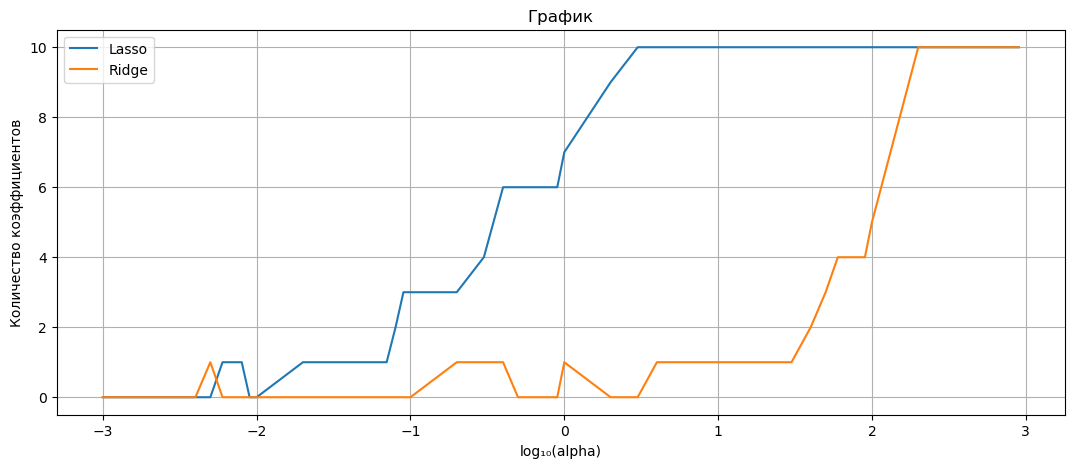

In [92]:
import matplotlib.pyplot as plt
import math


plt.figure(figsize=(13, 5))

log_alphas = [math.log(alpha, 10) for alpha in alphas]


plt.plot(log_alphas, Lasso_k, label='Lasso')
plt.plot(log_alphas, Ridge_k, label='Ridge')
plt.title(u"График")
plt.xlabel(u"log₁₀(alpha)")
plt.ylabel(u"Количество коэффициентов")
plt.grid(True)
plt.legend()
plt.show()

Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

regression = linear_model.Ridge()
regression.fit(X_train, y_train)
prediction = regression.predict(X_test)

RMSE = mean_squared_error(y_test, prediction) ** 0.5
print("RMSE", RMSE)

MAE = mean_absolute_error(y_test, prediction)
print("MAE", MAE)

R2 = r2_score(y_test, prediction)
print("R^2", R2)

RMSE 58.304295113912275
MAE 49.60275080965191
R^2 0.359902022000946


Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Постройте графики зависимости фукнции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

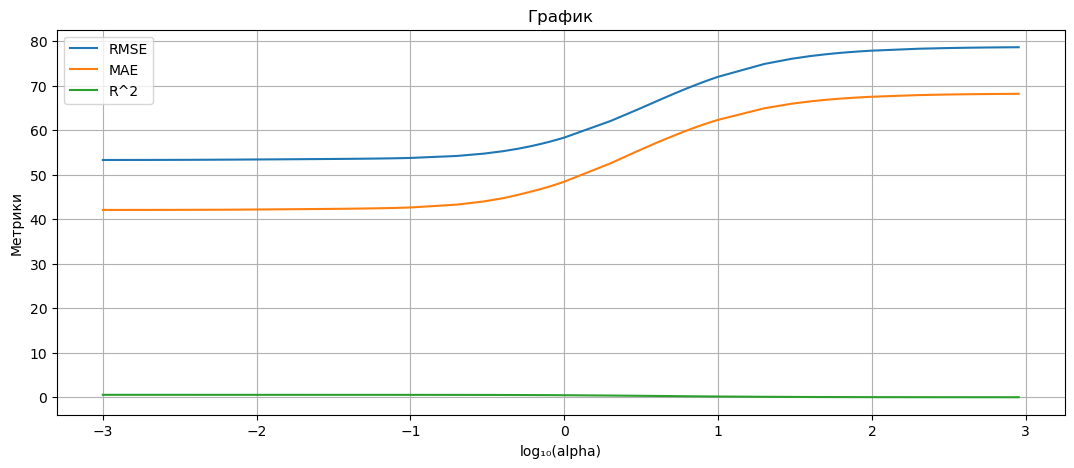

In [104]:
RMSEs, MAEs, R2s = [], [], []

def f(alpha):
    global RMSEs, MAEs, R2s
    regression = linear_model.Ridge(alpha=alpha)
    regression.fit(X_train, y_train)
    prediction = regression.predict(X_train)

    RMSE = mean_squared_error(y_train, prediction) ** 0.5
    RMSEs.append(RMSE)

    MAE = mean_absolute_error(y_train, prediction)
    MAEs.append(MAE)

    R2 = r2_score(y_train, prediction)
    R2s.append(R2)

for alpha in alphas:
    f(alpha)


plt.figure(figsize=(13, 5))

plt.plot(log_alphas, RMSEs, label='RMSE')
plt.plot(log_alphas, MAEs, label='MAE')
plt.plot(log_alphas, R2s, label='R^2')
plt.title(u"График")
plt.xlabel(u"log₁₀(alpha)")
plt.ylabel(u"Метрики")
plt.grid(True)
plt.legend()
plt.show()

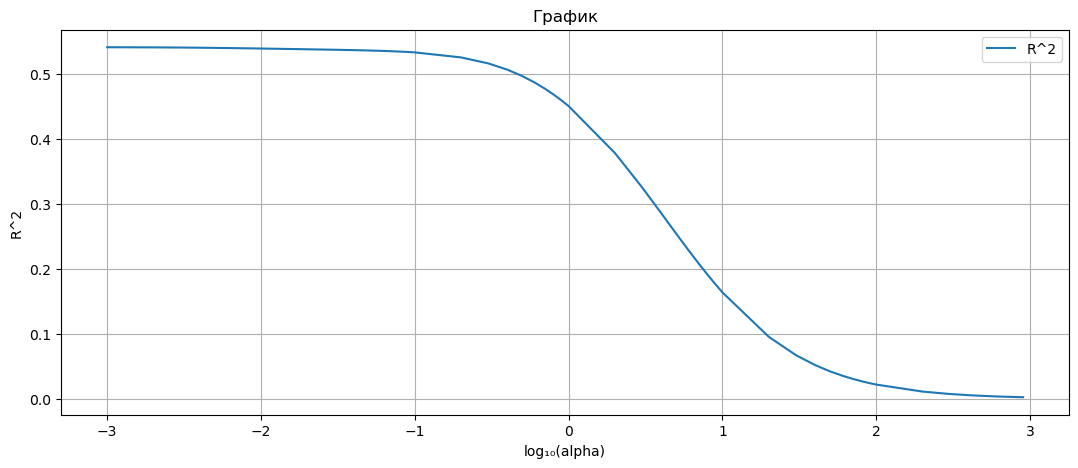

In [105]:
plt.figure(figsize=(13, 5))

plt.plot(log_alphas, R2s, label='R^2')
plt.title(u"График")
plt.xlabel(u"log₁₀(alpha)")
plt.ylabel(u"R^2")
plt.grid(True)
plt.legend()
plt.show()

In [106]:
regression = linear_model.Ridge(alpha=0.1)
regression.fit(X_train, y_train)
prediction = regression.predict(X_test)

RMSE = mean_squared_error(y_test, prediction) ** 0.5
print("RMSE", RMSE)

MAE = mean_absolute_error(y_test, prediction)
print("MAE", MAE)

R2 = r2_score(y_test, prediction)
print("R2", R2)

RMSE 55.64176122404913
MAE 47.375463757061304
R2 0.41702880920983465


In [ ]:
# Качество улучшилось

__Задание 2.__ Поиск объектов-выбросов

**(4 балла)**

Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

In [ ]:
# code here

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

In [ ]:
# code here

__Задание 3.__ Отчёт

**(2 балла)**

In [ ]:
# code here